# Calibrate GAM and NGAM

In [1]:
import pandas as pd
from reframed import FBA, Environment, load_cbmodel, save_cbmodel
from scipy.optimize import lsq_linear
import matplotlib.pyplot as plt
import numpy as np

In [2]:
model = load_cbmodel('../models/RcH10_v2.xml')

In [3]:
media = pd.read_csv('../input/media_db.tsv',sep='\t')
media_cellb = media[media.medium=='DM_cellobiose']
env_cellb = Environment.from_compounds(list(media_cellb['compound']))
env_cellb.apply(model, inplace=True, exclusive=True, warning=False)

In [4]:
chemostat= pd.read_excel('../input/Guedon1999_chemostat_data.xlsx', sheet_name='Sheet1', header=None, index_col=0, usecols="A:H")
mu = chemostat.iloc[0,:].values
q_cellb = chemostat.iloc[1,:].values

q_ac = chemostat.iloc[2,:].values * chemostat.iloc[3,:].values / 100
q_lac = chemostat.iloc[2,:].values * chemostat.iloc[4,:].values / 100
q_etoh = chemostat.iloc[2,:].values * chemostat.iloc[5,:].values / 100

In [5]:
#Setting GAM values in biomass function
model.reactions.Growth.stoichiometry['M_atp_c']=0
model.reactions.Growth.stoichiometry['M_adp_c']=0
model.reactions.Growth.stoichiometry['M_h_c']=0
model.reactions.Growth.stoichiometry['M_pi_c']=0

In [6]:
max_atp=[]

for i, mu_i in enumerate(mu):
    constraints = {
        'Growth':(mu_i, mu_i),
        'R_EX_cellb_e': (-q_cellb[i], -q_cellb[i]),
        'R_EX_ac_e':(q_ac[i], q_ac[i]),
        'R_EX_lac__L_e':(q_lac[i], q_lac[i]),
        'R_EX_etoh_e':(q_etoh[i], q_etoh[i]),
    }
    sol = FBA(model, constraints=constraints, objective={'R_ATPM': 1})
    max_atp.append(sol.fobj)

In [7]:
A = np.vstack([mu, np.ones((1,7))]).T
b = np.array(max_atp).T
opt = lsq_linear(A, b, bounds=[(0, 0), (100, min(max_atp))])
GAM, NGAM = round(opt.x[0], 1), round(opt.x[1], 1)

In [8]:
print(f'GAM:{GAM} NGAM: {NGAM}')

GAM:20.8 NGAM: 2.7


In [9]:
#Setting GAM values in biomass function
model.reactions.Growth.stoichiometry['M_atp_c']=-GAM
model.reactions.Growth.stoichiometry['M_adp_c']=GAM
model.reactions.Growth.stoichiometry['M_h_c']=GAM
model.reactions.Growth.stoichiometry['M_pi_c']=GAM

In [10]:
#Setting NGAM values in the ATPM function
model.reactions.R_ATPM.lb = NGAM

In [11]:
# predict max growth rate (secretion is constrained)
mu_sim = []

for i, mu_i in enumerate(mu):
    constraints = {
        'R_EX_cellb_e': (-q_cellb[i], -q_cellb[i]),
        'R_EX_ac_e':(q_ac[i], q_ac[i]),
        'R_EX_lac__L_e':(q_lac[i], q_lac[i]),
        'R_EX_etoh_e':(q_etoh[i], q_etoh[i]),
    }
    sol = FBA(model, constraints=constraints)
    mu_i = sol.fobj if sol.fobj is not None else 0
    mu_sim.append(mu_i)

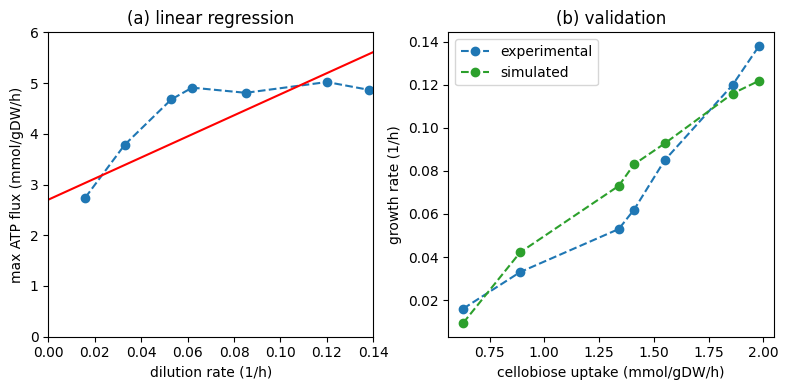

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(8,4))

axs[0].plot(mu, max_atp, 'o--')
axs[0].plot(np.arange(0, 0.15, 0.01), NGAM + GAM*np.arange(0, 0.15, 0.01), 'r')
axs[0].set_ylim(0, 6)
axs[0].set_xlim(0, 0.14)
axs[0].set_xlabel('dilution rate (1/h)')
axs[0].set_ylabel('max ATP flux (mmol/gDW/h)')
axs[0].set_title('(a) linear regression')

axs[1].plot(q_cellb, mu, 'o--')
axs[1].plot(q_cellb, mu_sim, 'o--', color='tab:green')
axs[1].set_xlabel('cellobiose uptake (mmol/gDW/h)')
axs[1].set_ylabel('growth rate (1/h)')
axs[1].legend(['experimental', 'simulated'])
axs[1].set_title('(b) validation')

fig.tight_layout()
fig.savefig('../figures/gam_ngam_calibration.png', dpi=300)

In [13]:
save_cbmodel(model, '../models/RcH10_final.xml')